# 신경망 학습 (MNIST in Pytorch)

In [38]:
import torch # 파이토치 기본 라이브러리 
import torchvision # 이미지 관련 된 파이토치 라이브러리
from torchvision import datasets # 토치비전에서 제공하는 데이터셋
from torchvision import transforms # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader # 데이터를 모델에 사용할 수 있도록 적재해 주는 라이브러리
from torch.utils.data import random_split
import numpy as np 
import matplotlib.pyplot as plt

## 1. 데이터 불러오기

In [2]:
# Compose 함수를 통해 원하는 전처리를 차례대로 넣을 수 있음
# transform = transforms.Compose([transforms.Resize(16), transforms.ToTensor()])
# trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
# trainset[0][0].size() # 결과 : torch.Size([1, 16, 16])

In [43]:
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transforms.ToTensor())
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transforms.ToTensor())

In [44]:
# trainset을 train용과 valid용으로 나누고 싶을 때
# torch.utils.data.random_split() 사용
# https://pytorch.org/docs/stable/data.html
trainset, validset = random_split(trainset, [50000, 10000])

In [45]:
print(type(trainset), len(trainset))
print(type(validset), len(validset))
print(type(testset), len(testset))

<class 'torch.utils.data.dataset.Subset'> 50000
<class 'torch.utils.data.dataset.Subset'> 10000
<class 'torchvision.datasets.mnist.MNIST'> 10000


In [5]:
# trainset[0][0] # tensor로 변환된 이미지 데이터
# trainset[0][1] # 이미지 데이터의 라벨(정답)
print(type(trainset[0][0]), type(trainset[0][1]))            

<class 'torch.Tensor'> <class 'int'>


In [6]:
# 일반적으로 opencv, matplotlib 에서 읽어드린 이미지 array는 height * width * channels 형상을 가짐
# 그러나 파이토치로 읽어드린 이미지 텐서는 channels * height * width 형상임을 유의
# 1 x 28 x 28 (1개의 채널에 높이는 28, 너비도 28인 이미지)

In [7]:
trainset[0][0].size() # trainset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
random_split

## 2. 데이터 시각화

- tensor를 matplotlib에서 표시했을 경우

In [8]:
sample_img = trainset[0][0]
sample_img.size()

torch.Size([1, 28, 28])

In [9]:
sample_img[0].size()

torch.Size([28, 28])

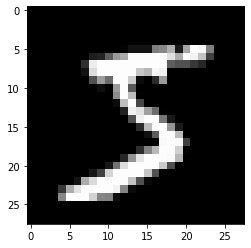

In [10]:
plt.imshow(sample_img[0], cmap='gray')

- numpy로 변환한 뒤 matplotlib으로 표시할 경우

In [11]:
sample_img.size()

torch.Size([1, 28, 28])

In [12]:
numpy_sample = sample_img.numpy()
numpy_sample.shape

(1, 28, 28)

In [13]:
type(numpy_sample)

numpy.ndarray

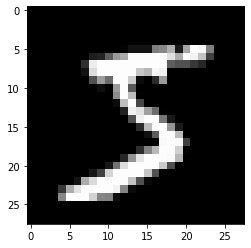

In [14]:
plt.imshow(numpy_sample[0], cmap='gray')

- tensor 자체에서 차원을 색인해서 사용하는 방법

In [15]:
sample_img.size()

torch.Size([1, 28, 28])

In [16]:
# permute는 차원을 변경
sample_t_permute = sample_img.permute(1, 2, 0)
sample_t_permute.size()

torch.Size([28, 28, 1])

In [17]:
# squeeze는 지정한 차원을 없앰
sample_t_permute_squeeze = sample_t_permute.squeeze(axis=2)
sample_t_permute_squeeze.size()

torch.Size([28, 28])

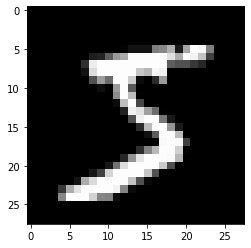

In [18]:
# permute->squeeze
sample_tensor = sample_img.permute(1, 2, 0).squeeze(axis=2)
plt.imshow(sample_tensor, cmap='gray')

In [19]:
# 컬러 이미지를 다룰 경우에는 squeeze 할 필요 없음
# color_sample = sample_img.permute(1, 2, 0)

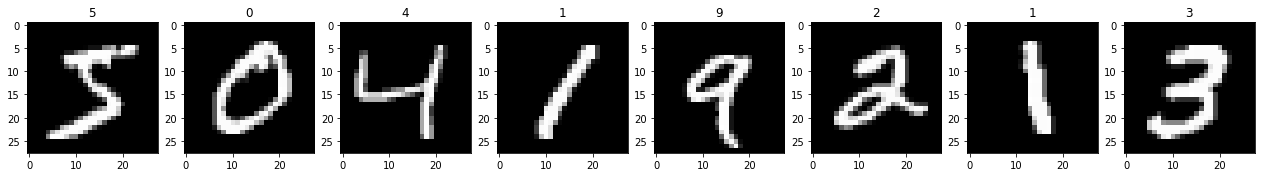

In [20]:
figure, axes = plt.subplots(nrows=1, ncols=8, figsize=(22, 6))
for i in range(8):
  axes[i].imshow(trainset[i][0][0], cmap='gray')
  axes[i].set_title(trainset[i][1])   

## 3. 데이터 적재

In [21]:
# torch.utils.data.DataLoader
# 데이터를 셔플하거나, 병렬로 데이터를 부르거나, 혹은 미니 배치 작업 단위로 데이터를 준비

In [46]:
batch_size = 100
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False) # 테스트용

In [47]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 500
<class 'torch.utils.data.dataloader.DataLoader'> 100
<class 'torch.utils.data.dataloader.DataLoader'> 100


In [ ]:
dir(trainloader)

In [25]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
print(images.size(), labels.size())

torch.Size([100, 1, 28, 28]) torch.Size([100])


## 4. 모델 생성

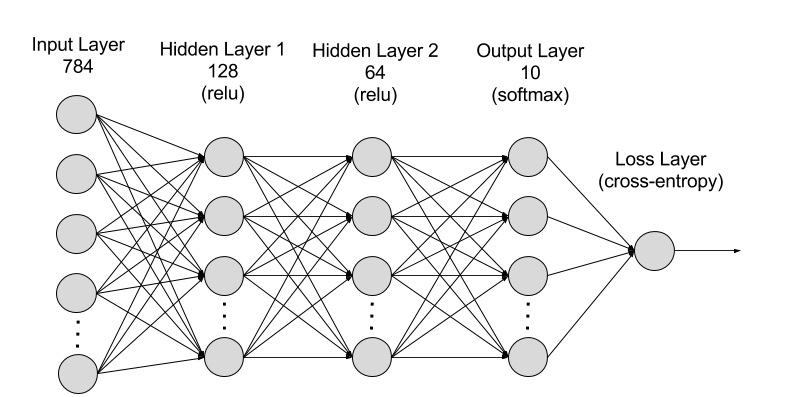

In [26]:
from torch import nn # 파이토치에서 제공하는 다양한 계층(Linear layer, Convolutional Layer...)
from torch import optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

In [27]:
        # W1, W2 = self.params['W1'], self.params['W2']
        # b1, b2 = self.params['b1'], self.params['b2']
        
        # a1 = np.dot(x, W1) + b1 # (784,) X (784, 20) + (20,)
        # z1 = sigmoid(a1) # (20,)
        
        # a2 = np.dot(z1, W2) + b2 # (20,) X (20, 10) + (10,)
        # y = softmax(a2) # (10,)
        

In [28]:
class MNIST_DNN(nn.Module):
  def __init__(self):
    super().__init__()
    # 계층 정의하기 784(input), 20(hiddle), 10(output)
    # fully connected layer(dense lyaer, affine layer) : np.dot(x, w) + b
    self.fc1 = nn.Linear(in_features=784, out_features=20) 
    self.fc2 = nn.Linear(in_features=20, out_features=10)
              

  def forward(self, x):
    x = self.fc1(x)
    x = F.sigmoid(x)
    x = self.fc2(x)
    # x = F.softmax(x)
    return x

In [29]:
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# nn.CrossEntorpyLoss() 문서에 보면 아래와 같이 언급
# Note that this case is equivalent to the combination of LogSoftmax and NLLLoss. 
# 즉 기존의 Softmax + CrosssEntropy 의 조합이  LogSoftMax + NLLLoss 조합으로 바뀌었음
# 따라서 CrossEntorpyLoss()를 손실함수로 사용하게 되면, 예측을 할 때 softmax() 는 사용하면 안됨

In [76]:
model = MNIST_DNN()
model


MNIST_DNN(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)

In [77]:
for parameter in model.parameters():
  print(parameter.size())

torch.Size([20, 784])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])


In [78]:
for name, parameter in model.named_parameters():
  print(name, parameter.size())

fc1.weight torch.Size([20, 784])
fc1.bias torch.Size([20])
fc2.weight torch.Size([10, 20])
fc2.bias torch.Size([10])


In [79]:
from torchsummary import summary

In [80]:
summary(model, (1, 784)) # (channle, input_size) # 참고 : Conv layer 사용시 (3, 28, 28)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 20]          15,700
            Linear-2                [-1, 1, 10]             210
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [81]:
784*20 + 20

15700

In [82]:
20*10 + 10

210

## 5. 모델 컴파일 (손실함수, 옵티마이저 선택)

In [83]:
learning_rate = 0.1 
# 손실함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저(경사하강법, 최적화 함수)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

## 6. 모델 훈련 (with 검증)

In [84]:
# torch.no_grad()
# https://pytorch.org/docs/stable/generated/torch.no_grad.html
# Context-manager that disabled gradient calculation.

# Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). 
# It will reduce memory consumption for computations that would otherwise have requires_grad=True.

In [85]:
def validation(model, validloader, criterion):
  # 전방향 예측후 나온 점수(logits)의 최대값을 최종 예측으로 준비
  # 이 최종 예측과 정답을 비교
  # 전체 중 맞은 것의 개수 비율을 정확도(accuracy)로 계산
  valid_accuracy = 0
  valid_loss = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음
  with torch.no_grad():
    for images, labels in validloader: # 10000개의 데이터에 대해 100개씩(미니배치 사이즈) 100번을 iterations
      # 1. 입력데이터 준비
      images.resize_(images.size()[0], 784) # 100, 1, 28, 28
      # 2. 전방향(Forward) 예측 
      logits = model.forward(images) # 점수 반환
      _, preds = torch.max(logits, 1) # 100개에 대한 최종 예측
      # preds= probs.max(dim=1)[1] 
      correct = (preds == labels).sum()

      accuracy = correct / images.shape[0]
      loss = criterion(logits, labels) # 100개에 대한 loss
      
      valid_accuracy += accuracy
      valid_loss += loss.item() # tensor 값을 꺼내옴
    

  return valid_loss, valid_accuracy # 100세트 전체 대한 총 loss, 총 accuracy


In [86]:
10000/600

16.666666666666668

In [88]:
epochs = 35
steps = 0

# 1 에폭(epoch)당 반복수
#steps_per_epoch = len(trainset)/batch_size # 500 iterations
steps_per_epoch = len(trainloader) # 500 iterations

for e in range(epochs):
  model.train()
  train_loss = 0
  for images, labels in iter(trainloader): # 이터레이터로부터 미니배치 100개씩을 가져와 images, labels에 준비
    steps += 1
    # 1. 입력 데이터 준비
    images.resize_(images.size()[0], 784) # 100, 1, 28, 28

    # 2. 전방향(Forward) 예측 
    outputs = model.forward(images) # 예측
    loss = criterion(outputs, labels) # 예측과 결과를 통해 Cross Entropy Loss 반환

    # 3. 역방향(Backward) 오차(Gradient) 전파
    optimizer.zero_grad() # 파이토치에서 gradient가 누적되지 않게 하기 위해
    loss.backward()

    # 4. 경사하강법으로 모델 파라미터 업데이트
    optimizer.step() # W <- W -lr*Gradient

    train_loss += loss.item()
    if (steps % steps_per_epoch) == 0: # step : 600, 1200, 1800 (epoch 마다)
      model.eval() # 배치 정규화, 드롭아웃이 적용될 때는 model.forward 연산이 training때와 다르므로 반드시 설정
      valid_loss, valid_accuracy = validation(model, validloader, criterion)
      print('Epoch : {}/{}.....'.format(e+1, epochs),
            'Train Loss : {:.3f}'.format(train_loss/len(trainloader)),
            'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)),
            'Valid Accuracy : {:.3f}'.format(valid_accuracy/len(validloader)))
      train_loss = 0
      model.train()

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch : 1/17..... Train Loss : 0.218 Valid Loss : 0.230 Valid Accuracy : 0.935
Epoch : 2/17..... Train Loss : 0.213 Valid Loss : 0.226 Valid Accuracy : 0.937
Epoch : 3/17..... Train Loss : 0.209 Valid Loss : 0.223 Valid Accuracy : 0.937
Epoch : 4/17..... Train Loss : 0.206 Valid Loss : 0.220 Valid Accuracy : 0.938
Epoch : 5/17..... Train Loss : 0.202 Valid Loss : 0.216 Valid Accuracy : 0.938
Epoch : 6/17..... Train Loss : 0.199 Valid Loss : 0.213 Valid Accuracy : 0.940
Epoch : 7/17..... Train Loss : 0.196 Valid Loss : 0.212 Valid Accuracy : 0.939
Epoch : 8/17..... Train Loss : 0.193 Valid Loss : 0.209 Valid Accuracy : 0.940
Epoch : 9/17..... Train Loss : 0.190 Valid Loss : 0.207 Valid Accuracy : 0.941
Epoch : 10/17..... Train Loss : 0.188 Valid Loss : 0.204 Valid Accuracy : 0.941
Epoch : 11/17..... Train Loss : 0.185 Valid Loss : 0.202 Valid Accuracy : 0.942
Epoch : 12/17..... Train Loss : 0.183 Valid Loss : 0.201 Valid Accuracy : 0.942
Epoch : 13/17..... Train Loss : 0.180 Valid Loss 

## 7. 모델 예측

In [96]:
test_iter = iter(testloader)
images, labels = next(test_iter)
print(images.size(), labels.size())

torch.Size([100, 1, 28, 28]) torch.Size([100])


In [104]:
rnd_idx = 10
images[rnd_idx].shape, labels[rnd_idx] # 1, 28, 28

(torch.Size([1, 28, 28]), tensor(0))

In [105]:
flattend_img = images[rnd_idx].view(1, 784)
with torch.no_grad():
  logit = model.forward(flattend_img)

pred = logit.max(dim=1)[1]
pred == labels[rnd_idx]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([True])

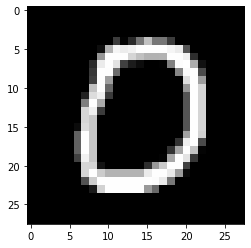

In [106]:
plt.imshow(images[rnd_idx][0], cmap='gray')

## 8. 모델 평가

In [94]:
def evaluation(model, testloader, criterion):
  # 전방향 예측후 나온 점수(logits)의 최대값을 최종 예측으로 준비
  # 이 최종 예측과 정답을 비교
  # 전체 중 맞은 것의 개수 비율을 정확도(accuracy)로 계산
  test_accuracy = 0
  test_loss = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음
  with torch.no_grad():
    for images, labels in testloader: # 10000개의 데이터에 대해 100개씩(미니배치 사이즈) 100번을 iterations
      # 1. 입력데이터 준비
      images.resize_(images.size()[0], 784) # 100, 1, 28, 28
      # 2. 전방향(Forward) 예측 
      logits = model.forward(images) # 점수 반환
      _, preds = torch.max(logits, 1) # 100개에 대한 최종 예측
      # preds= probs.max(dim=1)[1] 
      correct = (preds == labels).sum()

      accuracy = correct / images.shape[0]
      loss = criterion(logits, labels) # 100개에 대한 loss
      
      test_accuracy += accuracy.item()
      test_loss += loss.item() # tensor 값을 꺼내옴
    

  print('Test Loss : ', test_loss/len(testloader))
  print('Test Accuracy : ', test_accuracy/len(testloader))


In [95]:
evaluation(model, testloader, criterion)

Test Loss :  0.17979618845041842
Test Accuracy :  0.9482000041007995
